In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
from keras import backend as K
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
import sys
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.layers import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TerminateOnNaN
import keras.regularizers
import scipy
import math
import sys
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from scipy import interpolate
from scipy import signal
#import cPickle as pickle
#from video_process_utils import *
import collections
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0" 

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 84621376183108621
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6774193193
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16228679772910272266
physical_device_desc: "device: 0, name: Quadro M5000M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [9]:
mergedgdiavg_new_df = pd.read_csv('./data/test/labels/merged_gdiavg.csv', parse_dates = ["Event_Date"])

In [10]:
mergedgdiavg_new_df.head()

,Unnamed: 0,examid,Patient_ID,GDI,Event_Date,Video_File
0,0,32,3364.0,83.715617,1994-10-24,.\data\densepose-out\06988401-processed
1,1,35,3365.0,78.112851,1996-03-07,.\data\densepose-out\07022001-processed
2,2,36,3367.0,53.457512,1997-07-31,.\data\densepose-out\07337701-processed
3,3,37,3369.0,60.827350,1995-08-22,.\data\densepose-out\07399701-processed
4,4,40,3371.0,63.043201,1994-12-20,.\data\densepose-out\07720401-processed


In [12]:
d_mergedgdiavg_new_df = mergedgdiavg_new_df[True != mergedgdiavg_new_df['GDI'].isnull()]

In [14]:
image_path=d_mergedgdiavg_new_df['Video_File']
image_path.head()

0    .\data\densepose-out\06988401-processed
1    .\data\densepose-out\07022001-processed
2    .\data\densepose-out\07337701-processed
3    .\data\densepose-out\07399701-processed
4    .\data\densepose-out\07720401-processed
Name: Video_File, dtype: object

In [15]:
labels=d_mergedgdiavg_new_df['GDI']
labels.head()

0    83.715617
1    78.112851
2    53.457512
3    60.827350
4    63.043201
Name: GDI, dtype: float64

In [17]:
image_file_path = []
labels = []
for root, dirs, files in os.walk('./data/densepose-out'):
    if(root.endswith('processed')):
        image_dir_name = (root[root.rfind('\\')+1:])
        if(d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False).any()):
            dirImages = []
            img_cnt = 0
            for file in files:
                if(file.endswith('_IUV.png')):
                    image_file_path.append(os.path.join(root, file))
                    labels.append(d_mergedgdiavg_new_df.GDI[d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False)].values[0])

In [18]:
len(image_file_path)

234033

In [19]:
len(labels)

234033

In [21]:
image_path_series=pd.Series(image_file_path)
labels_series=pd.Series(labels)
imgaepath_gdi_df = pd.DataFrame()
imgaepath_gdi_df['image_path']=image_path_series.values
imgaepath_gdi_df['labels']=labels_series.values
imgaepath_gdi_df.head()

,image_path,labels
0,./data/densepose-out\07337701-processed\000053...,53.457512
1,./data/densepose-out\07337701-processed\000054...,53.457512
2,./data/densepose-out\07337701-processed\000055...,53.457512
3,./data/densepose-out\07337701-processed\000056...,53.457512
4,./data/densepose-out\07337701-processed\000057...,53.457512


In [161]:
imgaepath_gdi_df.to_csv('./data/test/labels/imagepath_gdi.csv')

In [143]:
imgaepath_gdi_df.at[imgaepath_gdi_df['labels'].idxmin(),'labels']

41.14290534476204

In [144]:
imgaepath_gdi_df.at[imgaepath_gdi_df['labels'].idxmax(),'labels']

113.2733105096525

In [152]:
for i in range(45,117,4):
    print(i)

45
49
53
57
61
65
69
73
77
81
85
89
93
97
101
105
109
113


In [154]:
label_norm=[]
for labels in imgaepath_gdi_df['labels']:
    #print(int(round(labels)))
    labelint = int(round(labels))
    if(labelint <= 45):
        label_norm.append('0')
    if(labelint > 45 and labelint <= 49):
        label_norm.append('1')
    if(labelint > 49 and labelint <= 53):
        label_norm.append('2')
    if(labelint > 53 and labelint <= 57):
        label_norm.append('3')
    if(labelint > 57 and labelint <= 61):
        label_norm.append('4')
    if(labelint > 61 and labelint <= 65):
        label_norm.append('5')
    if(labelint > 65 and labelint <= 69):
        label_norm.append('6')
    if(labelint > 69 and labelint <= 73):
        label_norm.append('7')
    if(labelint > 73 and labelint <= 77):
        label_norm.append('8')
    if(labelint > 77 and labelint <= 81):
        label_norm.append('9')
    if(labelint > 81 and labelint <= 85):
        label_norm.append('10')
    if(labelint > 85 and labelint <= 89):
        label_norm.append('11')
    if(labelint > 89 and labelint <= 93):
        label_norm.append('12')
    if(labelint > 93 and labelint <= 97):
        label_norm.append('13')
    if(labelint > 97 and labelint <= 101):
        label_norm.append('14')
    if(labelint > 101 and labelint <= 105):
        label_norm.append('15')
    if(labelint > 105 and labelint <= 109):
        label_norm.append('16')
    if(labelint > 109 and labelint <= 113):
        label_norm.append('17')

In [156]:
imgaepath_gdi_df['label_norm']=pd.Series(label_norm).values

In [160]:
imgaepath_gdi_df.head()

,image_path,labels,label_norm
0,./data/densepose-out\07337701-processed\000053...,53.457512,2
1,./data/densepose-out\07337701-processed\000054...,53.457512,2
2,./data/densepose-out\07337701-processed\000055...,53.457512,2
3,./data/densepose-out\07337701-processed\000056...,53.457512,2
4,./data/densepose-out\07337701-processed\000057...,53.457512,2


In [24]:
image_file_path2 = []
labels2 = []
for root, dirs, files in os.walk('./data/densepose-out'):
    if(root.endswith('processed')):
        image_dir_name = (root[root.rfind('\\')+1:])
        if(d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False).any()):
            img_cnt = 0
            for file in files:
                if(file.endswith('_IUV.png')):
                    image_file_path2.append(os.path.join(root, file))
                    labels2.append(d_mergedgdiavg_new_df.GDI[d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False)].values[0])
                    img_cnt+=1
                    if(img_cnt>10):
                        break;

In [25]:
image_path_series2=pd.Series(image_file_path2)
labels_series2=pd.Series(labels2)
imgaepath_gdi_df2 = pd.DataFrame()
imgaepath_gdi_df2['image_path']=image_path_series2.values
imgaepath_gdi_df2['labels']=labels_series2.values
imgaepath_gdi_df2.head()
imgaepath_gdi_df2.to_csv('./data/test/labels/imagepath_gdi_10.csv')

In [162]:
label_norm=[]
for labels in imgaepath_gdi_df2['labels']:
    #print(int(round(labels)))
    labelint = int(round(labels))
    if(labelint <= 45):
        label_norm.append('0')
    if(labelint > 45 and labelint <= 49):
        label_norm.append('1')
    if(labelint > 49 and labelint <= 53):
        label_norm.append('2')
    if(labelint > 53 and labelint <= 57):
        label_norm.append('3')
    if(labelint > 57 and labelint <= 61):
        label_norm.append('4')
    if(labelint > 61 and labelint <= 65):
        label_norm.append('5')
    if(labelint > 65 and labelint <= 69):
        label_norm.append('6')
    if(labelint > 69 and labelint <= 73):
        label_norm.append('7')
    if(labelint > 73 and labelint <= 77):
        label_norm.append('8')
    if(labelint > 77 and labelint <= 81):
        label_norm.append('9')
    if(labelint > 81 and labelint <= 85):
        label_norm.append('10')
    if(labelint > 85 and labelint <= 89):
        label_norm.append('11')
    if(labelint > 89 and labelint <= 93):
        label_norm.append('12')
    if(labelint > 93 and labelint <= 97):
        label_norm.append('13')
    if(labelint > 97 and labelint <= 101):
        label_norm.append('14')
    if(labelint > 101 and labelint <= 105):
        label_norm.append('15')
    if(labelint > 105 and labelint <= 109):
        label_norm.append('16')
    if(labelint > 109 and labelint <= 113):
        label_norm.append('17')

In [163]:
imgaepath_gdi_df2['labels_norm']=pd.Series(label_norm).values
imgaepath_gdi_df2.to_csv('./data/test/labels/imagepath_gdi_10.csv')

In [27]:
msk = np.random.rand(len(imgaepath_gdi_df2)) < 0.8
train=imgaepath_gdi_df2[msk]
validation=imgaepath_gdi_df2[~msk]

In [28]:
len(train)

3834

In [30]:
len(validation)

951

In [31]:
train.head()

,image_path,labels
0,./data/densepose-out\07337701-processed\000053...,53.457512
1,./data/densepose-out\07337701-processed\000054...,53.457512
2,./data/densepose-out\07337701-processed\000055...,53.457512
3,./data/densepose-out\07337701-processed\000056...,53.457512
4,./data/densepose-out\07337701-processed\000057...,53.457512


In [2]:
def ImportImage(filepath):
    #print(filepath)
    img = Image.open(filepath)
    return np.array(img)

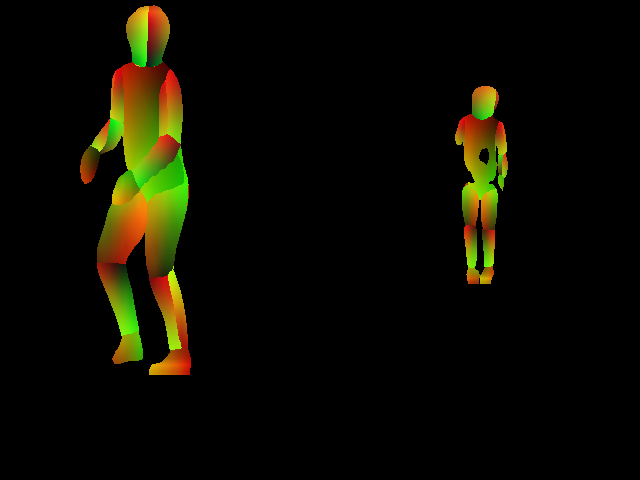

In [38]:
img

In [40]:
print(np.array(img).shape)

(480, 640, 3)


In [3]:
imagepaths_labels = pd.read_csv('./data/test/labels/imagepath_gdi_10.csv')
msk = np.random.rand(len(imagepaths_labels)) < 0.8
train=imagepaths_labels[msk]
validation=imagepaths_labels[~msk]

In [4]:
train_imgs = np.array([ImportImage(img) for img in train['image_path'].values])
train_labels = np.array([label for label in train['labels_norm'].values])
validation_imgs = np.array([ImportImage(img) for img in validation['image_path'].values])
validation_labels = np.array([label for label in validation['labels_norm'].values])

In [5]:
print('train images shape : ',train_imgs.shape)
print('train labels shape : ',train_labels.shape)
print('validation images shape : ',validation_imgs.shape)
print('validation labels shape : ',validation_labels.shape)

train images shape :  (3834, 480, 640, 3)
train labels shape :  (3834,)
validation images shape :  (951, 480, 640, 3)
validation labels shape :  (951,)


In [141]:
#imagepaths_labels.labels.unique().count()
#imagepaths_labels.groupby('labels')['image_path'].nunique()
#imagepaths_labels.labels.round()
imagepaths_labels.at[imagepaths_labels['labels'].idxmax(),'labels']

113.2733105096525

In [142]:
imagepaths_labels.at[imagepaths_labels['labels'].idxmin(),'labels']

41.14290534476204

In [167]:
print( "%d training images" %train_imgs.shape[0])

print( "Nbr of samples/class\tNbr of classes")
for index, val in train['labels_norm'].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

3834 training images
Nbr of samples/class	Nbr of classes
9			1
10			1
17			1
22			1
49			1
65			1
68			1
79			1
104			1
149			1
270			1
304			1
337			1
383			1
388			1
467			1
528			1
585			1


In [168]:
print( "%d training images" %validation_imgs.shape[0])

print( "Nbr of samples/class\tNbr of classes")
for index, val in validation['labels_norm'].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

951 training images
Nbr of samples/class	Nbr of classes
1			1
2			1
5			1
9			1
11			1
12			1
17			1
20			1
28			1
49			1
71			1
81			1
85			1
90			1
92			1
116			1
121			1
141			1


In [117]:
ImageToLabelDict = dict( zip( train['image_path'], train['labels']))
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train['image_path']))
lohe = LabelOneHotEncoder()
ylabels = lohe.fit_transform(y)

In [120]:
ImageToLabelDict_valid = dict( zip( validation['image_path'], validation['labels']))
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y_valid = list(map(ImageToLabelDict_valid.get, validation['image_path']))
lohe_valid = LabelOneHotEncoder()
ylabels_valid = lohe.fit_transform(y_valid)

In [124]:
print(ylabels.shape)

(3834, 435)


In [125]:
print(ylabels_valid.shape)

(951, 393)


In [6]:
def step_decay(initial_lrate,epochs_drop,drop_factor):
    def step_decay_fcn(epoch):
        return initial_lrate * math.pow(drop_factor, math.floor((1+epoch)/epochs_drop))
    return step_decay_fcn

checkpoint_folder = "./cnn_checkpoints_gdicnn"
batch_size  = 32
num_classes = len(train_labels)
epochs = 10
epochs_drop,drop_factor = (10,0.8)
input_shape = train_imgs[0].shape
kernel_size = 8
conv_dim = 64
initial_lrate = 0.001
dropout_amount = 0.5
l2_lambda = 10**(-3.5)
last_layer_dim=18

In [11]:
model = Sequential()
model.add(Conv2D(conv_dim, kernel_size=kernel_size, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=keras.regularizers.l2(l2_lambda)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(dropout_amount))
model.add(Flatten())
model.add(Dense(last_layer_dim,activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
train_model = True

if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

filepath=checkpoint_folder+"/weights-{epoch:02d}-{val_loss_2:.4f}.hdf5"
if train_model:

    #opt = RMSprop(lr=0.0,rho=0.9, epsilon=1e-08, decay=0.0)
    #model.compile(loss=mse_opt,metrics=[mse_metric],optimizer=opt)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])


    checkpoint = \
        ModelCheckpoint(filepath, monitor='val_loss_2', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    lr = LearningRateScheduler(step_decay(initial_lrate,epochs_drop,drop_factor))

    history = model.fit(train_imgs, train_labels,callbacks=[checkpoint,lr,TerminateOnNaN()],
              validation_data=(validation_imgs,validation_labels),
              batch_size=batch_size, epochs=epochs,shuffle=True)

Train on 3834 samples, validate on 951 samples
Epoch 1/10
